In [202]:
# import modules
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from sklearn.metrics import confusion_matrix, log_loss, f1_score

import random
from math import floor
from scipy.stats import mode, scoreatpercentile

print("Seaborn version : ", sns.__version__)
sns.set()
#sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_theme(style="ticks", palette="pastel")



# upload data
train = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/train.csv',
                   index_col=0)
test = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/test.csv',
                  index_col=0)
submit = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/sample_submission.csv')

Seaborn version :  0.11.1


In [203]:
df = train.copy()

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

In [205]:
# defs
def show_4digits(x) : 
    return str(x)[:3]



In [206]:
# outliers
df.drop((df[df['child_num']>=6]).index, inplace = True)

# no information
df.drop('FLAG_MOBIL',axis = 1, inplace = True)

# negative to positive
df['DAYS_BIRTH'] = -df['DAYS_BIRTH']
df['DAYS_EMPLOYED'] = -df['DAYS_EMPLOYED']
df['begin_month'] = -df['begin_month']

# handling the missing values
## occyp_type == NaN
df['occyp_type'] = df.occyp_type.fillna('missing')
df.loc[(df.DAYS_EMPLOYED == -365243)&(df.occyp_type.isna()), 'occyp_type'] = 'in_occyp'
## DAYS_EMPLOYED == 365243
df['DAYS_EMPLOYED'][df['DAYS_EMPLOYED'] == -365243] = 0

In [207]:
# personal_id
df['personal_id']= \
df['gender']+\
df['car']+\
df['income_total'].apply(lambda x: str(int(x)).zfill(7))+\
df['edu_type'].apply(show_4digits)+\
df['family_type'].apply(show_4digits)+\
df['house_type'].apply(show_4digits)+\
df['DAYS_BIRTH'].apply(lambda x: str(x).zfill(5))+\
df['DAYS_EMPLOYED'].apply(lambda x: str(x).zfill(5))+\
df['occyp_type'].apply(show_4digits)

# 재산, 연락처에 관한 정보들을 묶어서 분류
df['group_property'] = df['car'].astype(str)   + df['reality'].astype(str)
df['group_contacts'] = df['phone'].astype(str) + df['work_phone'].astype(str) + df['email'].astype(str)

In [208]:
# 현재 하고 있는 일을 시작하게 된 나이(날짜) = 일을 하지 않았던 기간 
df['DAYS_nowork'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']

# 가족 수와 관련된 변수
df['adult_num'] = df['family_size'] - df['child_num']
df.loc[df.child_num >= 5, 'child_num'] = 5
df.loc[df.child_num >= 5, 'family_size'] = df.loc[df.child_num >= 5, 'child_num'] + df.loc[df.child_num >= 5, 'adult_num']

# 소득과 관련된 변수와 조합
df['income_per_child'] = df['income_total']/ df['child_num']  #소득을 아이 수로 나눠 각 아이에게 할당 될 수 있는 금액을 계산 
df['income_per_family']= df['income_total']/ df['family_size']#소득을 가족 수로 나눠 각 인원에게 할당 될 수 있는 금액을 계산
df['income_per_age']   = df['income_total']/ df['DAYS_BIRTH'] #소득을 나이로 나눠 나이 대비 얼마나 버는지에 대한 지표 생성

# 로그 변환(income_total)
df['income_total_log'] = np.log(df['income_total']+1)

# 날짜표기 변환(begin_month) : 4로 나누어 계절로 분할
df['begin_season'] = df['begin_month'].apply(lambda x: floor(x/4))

# 날짜표기 변환(DAYS_EMPLOYED) : 개월로 binning
df['mm_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/30.4375))

# 날쨔 표기 변환(DAYS_EMPLOYED): 연차로 binning
df['yy_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/365.25))



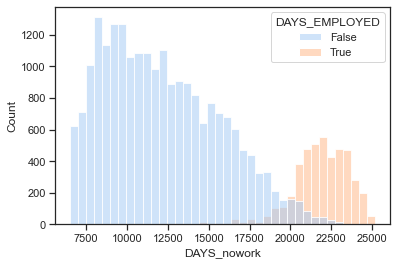

In [209]:
sns.histplot(x = df.DAYS_nowork, hue = df.DAYS_EMPLOYED == 0)

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26451 entries, 0 to 26456
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             26451 non-null  object 
 1   car                26451 non-null  object 
 2   reality            26451 non-null  object 
 3   child_num          26451 non-null  int64  
 4   income_total       26451 non-null  float64
 5   income_type        26451 non-null  object 
 6   edu_type           26451 non-null  object 
 7   family_type        26451 non-null  object 
 8   house_type         26451 non-null  object 
 9   DAYS_BIRTH         26451 non-null  int64  
 10  DAYS_EMPLOYED      26451 non-null  int64  
 11  work_phone         26451 non-null  int64  
 12  phone              26451 non-null  int64  
 13  email              26451 non-null  int64  
 14  occyp_type         26451 non-null  object 
 15  family_size        26451 non-null  float64
 16  begin_month        264

In [211]:
# outliers
train.drop((train[train['child_num']>=6]).index, inplace = True)

In [212]:
for df in [train, test] : 
    # no information
    df.drop('FLAG_MOBIL',axis = 1, inplace = True)

    # negative to positive
    df['DAYS_BIRTH'] = -df['DAYS_BIRTH']
    df['DAYS_EMPLOYED'] = -df['DAYS_EMPLOYED']
    df['begin_month'] = -df['begin_month']

    # handling the missing values
    ## occyp_type == NaN
    df['occyp_type'] = df.occyp_type.fillna('missing')
    df.loc[(df.DAYS_EMPLOYED == -365243)&(df.occyp_type.isna()), 'occyp_type'] = 'in_occyp'
    ## DAYS_EMPLOYED == 365243
    df['DAYS_EMPLOYED'][df['DAYS_EMPLOYED'] == -365243] = 0

In [213]:
for df in [train, test] : 
    # personal_id
    df['personal_id']= \
    df['gender']+\
    df['car']+\
    df['income_total'].apply(lambda x: str(int(x)).zfill(7))+\
    df['edu_type'].apply(show_4digits)+\
    df['family_type'].apply(show_4digits)+\
    df['house_type'].apply(show_4digits)+\
    df['DAYS_BIRTH'].apply(lambda x: str(x).zfill(5))+\
    df['DAYS_EMPLOYED'].apply(lambda x: str(x).zfill(5))+\
    df['occyp_type'].apply(show_4digits)

    # 재산, 연락처에 관한 정보들을 묶어서 분류
    df['group_property'] = df['car'].astype(str)   + df['reality'].astype(str)
    df['group_contacts'] = df['phone'].astype(str) + df['work_phone'].astype(str) + df['email'].astype(str)
    df['group_whoare_u'] = df['gender'].astype(str)+ df['family_type'].astype(str)

In [214]:
for df in [train, test] : 
    # 현재 하고 있는 일을 시작하게 된 나이(날짜) = 일을 하지 않았던 기간 
    df['DAYS_nowork'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']

    # 가족 수와 관련된 변수
    df['adult_num'] = df['family_size'] - df['child_num']
    df.loc[df.child_num >= 5, 'child_num'] = 5
    df.loc[df.child_num >= 5, 'family_size'] = df.loc[df.child_num >= 5, 'child_num'] + df.loc[df.child_num >= 5, 'adult_num']

    # 소득과 관련된 변수와 조합
    df['income_per_child'] = df['income_total']/ df['child_num']  #소득을 아이 수로 나눠 각 아이에게 할당 될 수 있는 금액을 계산 
    df['income_per_family']= df['income_total']/ df['family_size']#소득을 가족 수로 나눠 각 인원에게 할당 될 수 있는 금액을 계산
    df['income_per_age']   = df['income_total']/ df['DAYS_BIRTH'] #소득을 나이로 나눠 나이 대비 얼마나 버는지에 대한 지표 생성

    # 로그 변환(income_total)
    df['income_total_log'] = np.log(df['income_total']+1)

    # 날짜표기 변환(begin_month) : 4로 나누어 계절로 분할
    df['begin_season'] = df['begin_month'].apply(lambda x: floor(x/4))

    # 날짜표기 변환(DAYS_EMPLOYED) : 개월로 binning
    df['mm_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/30.4375))

    # 날쨔 표기 변환(DAYS_EMPLOYED): 연차로 binning
    df['yy_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/365.25))



In [215]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26451 entries, 0 to 26456
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             26451 non-null  object 
 1   car                26451 non-null  object 
 2   reality            26451 non-null  object 
 3   child_num          26451 non-null  int64  
 4   income_total       26451 non-null  float64
 5   income_type        26451 non-null  object 
 6   edu_type           26451 non-null  object 
 7   family_type        26451 non-null  object 
 8   house_type         26451 non-null  object 
 9   DAYS_BIRTH         26451 non-null  int64  
 10  DAYS_EMPLOYED      26451 non-null  int64  
 11  work_phone         26451 non-null  int64  
 12  phone              26451 non-null  int64  
 13  email              26451 non-null  int64  
 14  occyp_type         26451 non-null  object 
 15  family_size        26451 non-null  float64
 16  begin_month        264

In [216]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
#numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  19
Number of Categorical features:  12


In [217]:
target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [218]:
seed = 42
n_fold = 5
n_class = 3

In [219]:
skfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=55)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats
print('category features : {}'.format(cat_cols))

# 15Fold-CV (StratifiedKFold)
for fold in range(len(folds)):
    print(f'\n----------------- Fold {fold+1} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(n_estimators=3000, max_depth=8, random_seed=1042, learning_rate=0.04, bootstrap_type ='Bernoulli')
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / len(folds)
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

category features : ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'group_property', 'group_contacts', 'group_whoare_u']

----------------- Fold 1 -----------------

0:	learn: 1.0754283	test: 1.0758071	best: 1.0758071 (0)	total: 56.1ms	remaining: 2m 48s
100:	learn: 0.7168957	test: 0.6867844	best: 0.6867844 (100)	total: 3.38s	remaining: 1m 37s
200:	learn: 0.7008775	test: 0.6800095	best: 0.6799460 (194)	total: 8.41s	remaining: 1m 57s
300:	learn: 0.6877509	test: 0.6767133	best: 0.6765690 (297)	total: 14s	remaining: 2m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6756011436
bestIteration = 335

Shrink model to first 336 iterations.
CV Log Loss Score: 0.675601

----------------- Fold 2 -----------------

0:	learn: 1.0754606	test: 1.0756085	best: 1.0756085 (0)	total: 61.5ms	remaining: 3m 4s
100:	learn: 0.7188207	test: 0.6680826	best: 0.6680826 (100)	total: 4.08s	remaining: 1m 57s
200:	learn: 0.704091

100:	learn: 0.7192150	test: 0.6720600	best: 0.6720600 (100)	total: 4.81s	remaining: 2m 18s
200:	learn: 0.7036755	test: 0.6641080	best: 0.6641080 (200)	total: 10.8s	remaining: 2m 29s
300:	learn: 0.6911349	test: 0.6609132	best: 0.6609132 (300)	total: 17.7s	remaining: 2m 38s
400:	learn: 0.6773377	test: 0.6599889	best: 0.6599774 (398)	total: 24.7s	remaining: 2m 40s
500:	learn: 0.6647052	test: 0.6593290	best: 0.6592858 (499)	total: 31.6s	remaining: 2m 37s
600:	learn: 0.6512621	test: 0.6585514	best: 0.6585514 (600)	total: 38.5s	remaining: 2m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6583792248
bestIteration = 625

Shrink model to first 626 iterations.
CV Log Loss Score: 0.658379

----------------- Fold 13 -----------------

0:	learn: 1.0754622	test: 1.0755170	best: 1.0755170 (0)	total: 71.4ms	remaining: 3m 34s
100:	learn: 0.7168098	test: 0.6783020	best: 0.6783020 (100)	total: 5.48s	remaining: 2m 37s
200:	learn: 0.7015605	test: 0.6707220	best: 0.6706969 (199)	tot

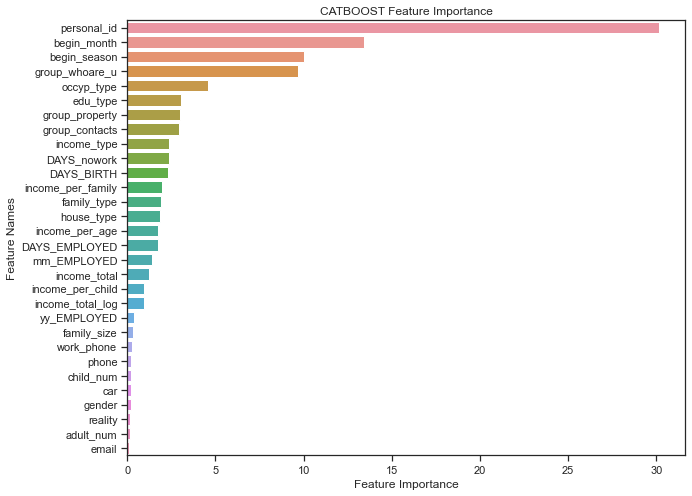

In [220]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [221]:
for i in range(3):
    submit[str(i)] = (cat_pred_test)[:,i]

In [222]:
submit.set_index('index').apply(np.argmax, axis = 1).value_counts()

2    8098
1    1412
0     490
dtype: int64

In [223]:
submit.to_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/preprocessing/catboost_renew_2.csv', index = False)

In [201]:
model_cat.best_score_

{'learn': {'MultiClass': 0.6667556801933746},
 'validation': {'MultiClass': 0.6697937756146143}}